### Homework

Create a new convolutional module and implement it by deriving it from nn.Module.
Then, use it in a neural network and test it in CIFAR10.

Your creativity and the documentation are your best friends ;)
Remember that a a layer is just a function transforming a tensor. So, I am asking you to think of
transformation $f: \mathcal{R}^{b \times c_1 \times l_1 \times l_1} \rightarrow \mathcal{R}^{b \times c_2 \times l_2 \times l_2}$.

Don't be scared by all those superscripts. During the training, you are dealing with minibatches of images, which are
just 4-order arrays:
- the first dimension is the batch axis, and $b$ is the batch size;
- the second dimension indicates the number of channels of your filters, $c$;
- the third and fourth dimensions indicates the height and width of the input and output filters.
They are typically the same, since we deal with square $l\times l$ filters, but in general they could be different.

Notice that in our bottleneck layer we had $l_1 = l_2$ and $c_1 = c_2$.
The bottleneck transformation preserves the tensor dimension.

Have fun, and for now, do not worry to much about getting super performance. As usual, for any question or advise you
can reach me by email.



**Solution.**

In [5]:
import numpy as np
from utils.misc import get_params_num, get_accuracy
from utils.visual import imshow

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from IPython import display

torch.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))

Device: cpu


In [7]:
# import CIFAR10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
nclasses = len(classes)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print("trainset.data type: {}".format(type(trainset.data)))
dim = tuple(trainset[0][0].shape)
inputdim = dim[0] * dim[1] * dim[2]
print("CIFAR images shape: {}".format(dim))

trainset.data type: <class 'numpy.ndarray'>
CIFAR images shape: (3, 32, 32)


torch.Size([64, 3, 32, 32]) torch.Size([64])


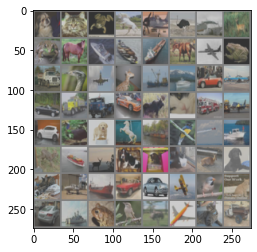

  dog   cat horse monkey airplane   car  ship  deer horse monkey  ship  ship  ship monkey airplane horse truck   car airplane  deer  ship  ship  bird airplane  bird truck truck  bird  deer   cat truck airplane


In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))

In [23]:
class CNN(nn.Module):
    def __init__(self, dim, nclasses):
        super(CNN, self).__init__()
        self.input_dim = dim[0] * dim[1] * dim[2]
        self.n_classes = nclasses
        C = 128
        D = 256
        
        self.conv1 = nn.Conv2d(in_channels=dim[0], out_channels=dim[1], kernel_size=3)
        self.conv2 = nn.Conv2d(dim[1], C, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.25)
        #self.linear = nn.Linear(C, D)
        self.avgpool = nn.AvgPool2d(kernel_size=2)
        self.out = nn.Linear(C * 6 * 6, self.n_classes)
        
    def forward(self, x, verbose=False):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x) # F.max_pool2d(x, kernel_size=2)
        x = F.leaky_relu(self.conv2(x))
        x = self.avgpool(x)
        x = self.dropout(x)
        #x = F.tanh(self.linear(x))
        x = torch.tanh(x)
        #x = self.avgpool(x)
        x = x.view(-1, 128 * 6 * 6)
        x = self.out(x)
        return x
    
net = CNN(dim, nclasses)
net.to(device)
print("# of parameters: {}".format(get_params_num(net)))
print(net)

# of parameters: 83978
CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (out): Linear(in_features=4608, out_features=10, bias=True)
)


In [26]:
lr = 0.001
momentum = 0.9
epochs = 10 # 20 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

n_batches = len(trainloader)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

net.train() 
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)

[EPOCH]: 9, [BATCH]: 750/782, [LOSS]: 1.2013009786605835


In [27]:
acc_train = get_accuracy(trainloader, net, device=device)
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.62342
Test accuracy: 0.608
